# !! Current !!

# 11_fMRI_Correlations.ipynb

Using our [toolbox](http://neurolearn.readthedocs.io/en/latest/index.html) there's 2 main python classes that can help achieve ISC analysis:  

1) Brain_Data, which is a 1d or 2d representation of a nifti file. In the cases of something like an image with 1 value at each voxel (e.g beta map, T1, etc) this will be a single 1d vector of voxel values. In the case of something with more than 1 value at each voxel (e.g. fMRI time-series, concatenated beta-maps from multiple subjects), this will be a 2d vector of observations X  voxels.  

    - This class has a bunch of methods on it to do stuff like simple arithmetic operations, to more sophisticated things like regression, extracting a time-series from a mask, etc

2) Adjacency, which is a 1d or 2d representation of a distance matrix or several distance matrices. If theres just 1 distance matrix this will be a single 1d vector (i.e. flattened upper triangle if the matrix is symmetrical, or all values stretched out if it isn't). If there is more than 1 distance matrix this will be a 2d vector of observations X flattened matrix values.  

    - This class also has a bunch of methods just like Brain_Data

You'll need 2 things to do an ISC analysis:  

1) Nifti file(s) containing ROI masks within which to compute ISC - this can either be a single 4d file that several ROI masks within it, a single 3d file with just 1 ROI mask, a single 3d file within multiple ROIs indicated by different non-overlapping integer value at each voxel  

2) 4d Nifti files for all subjects to correlate

In [25]:
import nltools
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os

% matplotlib inline

In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

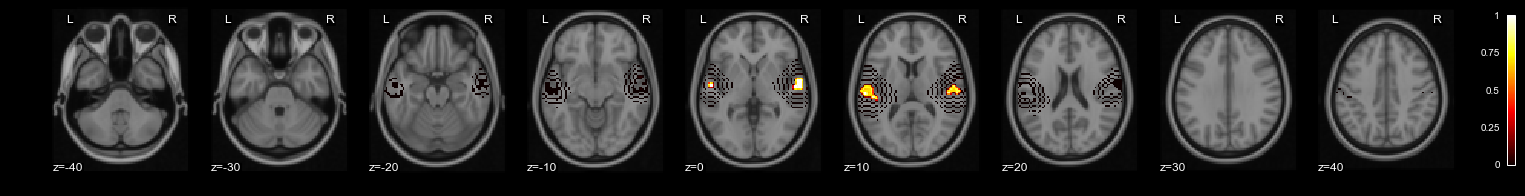

In [79]:
## Set up Folders

folder_path = "."

## Set up Mask

mask = 'a1_rev.nii'
mask_region = "a1_rev"

# mask = 'vDMN.nii.gz'
# mask_region = 'vDMN'

## Set up Video and Participantsd
video = 7
subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
num_subs = len(subjects)

#subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
#num_TRs = Brain_Data(subject).shape()[0]
    
    
# View Mask
mask = Brain_Data(data = folder_path + '/masked_csv/' + mask) # this now a 1d array of voxels containing 1's and 0s
mask.plot()

In [9]:
#Lets say you want to compute the ISC within an ROI (i.e. the pair-wise correlation of subjects average time-series across the entire ROI)
#Below assumes you have just a single mask, but you can easily adapt this by adding another loop over ROIs, e.g. for roi in mask: ...

#Get masked timeseries (averaged)


# for video in range(1,17):
#     subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
#     num_subs = len(subjects)

#     subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
#     num_TRs = Brain_Data(subject).shape()[0]

#     subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

#     for i, subject in enumerate(subjects):

#         try:

#             subject_path = os.path.join(folder_path,'data', 'sub-' + subject, 'func', 'video_' + str(video) + '.nii.gz')
#             print(subject_path)

#             # Load in their data
#             sub_dat = Brain_Data(subject_path)

#             # Extract mean time-series from ROI
#             sub_roi = sub_dat.extract_roi(mask)

#             data_frame = pd.DataFrame(sub_roi)
#             output = os.path.join(folder_path, 'masked_csv', mask_region, subject + '_video' + str(video) + 'mask.csv')

#             data_frame.to_csv(output, header=None)

#         except:
#             print(subject_path + " failed")
#             pass

In [16]:
# pd.DataFrame(subject_timeseres)
# pairwise_distances(subject_timeseres,metric='correlation')


In [15]:
# ## Load data and compute ISC

# for video in range(1,2):

#     #Cutting off time series as a problem solivng measure
#     subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')

#     num_TRs = Brain_Data(subject).shape()[0] - 3

#     subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

#     for i, subject in enumerate(subjects):
#         csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")
#         #print(subject)

#         try: 
#             # Load in their data
#             sub_roi = pd.read_csv(csv_path, header=None)
#             subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs ,1] # just grab the numpy array values (normally just [1])
#         except: pass

#     # Now compute pairwise correlations 
#     sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

#     panda_corrs = pd.DataFrame(sub_corrs)
#     panda_corrs.columns = subjects
#     panda_corrs.index = subjects

#     pd.DataFrame(panda_corrs).to_csv('./masked_csv/' + mask_region + '/video_' \
#                                       + str(video)\
#                                       + '_fMRIcorrelations.csv')



#     # Save it as an adjacency matrix
#     sub_ISC = Adjacency(data=sub_corrs)

# panda_corrs

# For analyzing aud1 specifically (saved in wrong format)

In [28]:
subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')

Brain_Data(subject).shape()[0]


FileNotFoundError: No such file or no access: './data/sub-145/func/video_7.nii.gz'

In [14]:
# for video in range(1,17):
#     #Cutting off time series as a problem solivng measure
#     subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
    

#     num_TRs = Brain_Data(subject).shape()[0] - 5


#     subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

#     for i, subject in enumerate(subjects):
#         csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")

#         try: 
#                 # Load in their data
#             sub_roi = pd.read_csv(csv_path, header=None)
#             sub_roi = sub_roi.transpose()#only for aud_1
#             subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 1:num_TRs + 1,0] # just grab the numpy array values (normally just [1])
#         except: pass


#     # Now compute pairwise correlations 
#     sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

#     panda_corrs = pd.DataFrame(sub_corrs)
#     panda_corrs.columns = subjects
#     panda_corrs.index = subjects


#     pd.DataFrame(panda_corrs).to_csv('./masked_csv/' + mask_region + '/video_' \
#                                       + str(video)\
#                                       + '_fMRIcorrelations.csv')


#     # Save it as an adjacency matrix
#     sub_ISC = Adjacency(data=sub_corrs)


a1_rev


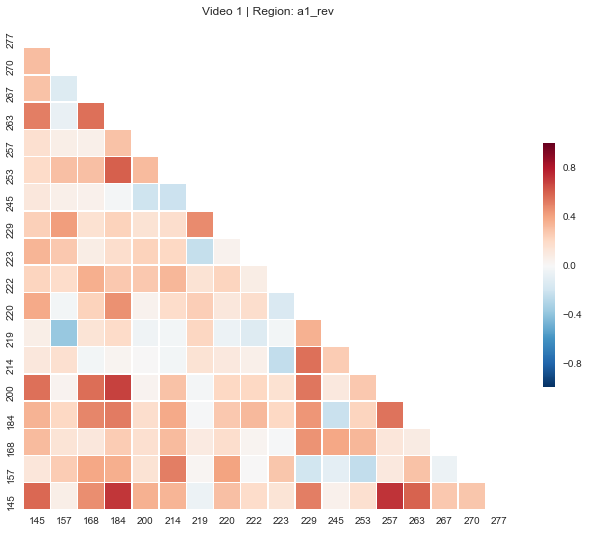

In [30]:
print(mask_region)

for video in range(1,2):

    csv_path = os.path.join(folder_path, 'masked_csv', mask_region, 'video_' + str(video) + '_fMRIcorrelations.csv')
    sub_corrs = pd.read_csv(csv_path, index_col=0)
    

    ## Plot Group ISC

    sns.set(style="white")

    # Compute the correlation matrix
    corr = sub_corrs

    # Genesampling_rate a mask for the upper triangle
    mask2 = np.zeros_like(corr, dtype=np.bool)
    mask2[np.triu_indices_from(mask2)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))


    sns.heatmap(corr, center=0,
                square=True, mask=mask2, linewidths=.5, cbar_kws={"shrink": .5})

    ax.set_xticklabels(subjects); 
    ax.set_yticklabels(subjects); 
    ax.set_title("Video " + str(video) + " | Region: " + mask_region)


## Plot Time Series Data

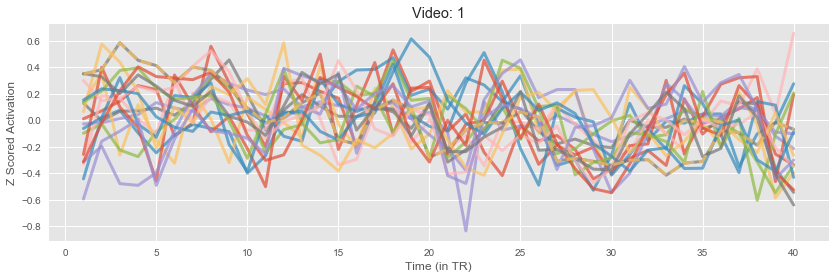

In [31]:
for video in range(1,2):
    #Cutting off time series as a problem solivng measure
    #subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
    
    #num_TRs = Brain_Data(subject).shape()[0] - 5
    num_TRs = 40

    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    for i, subject in enumerate(subjects):
        csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")

        try: 
        
            if mask_region == 'a1_rev':
                # Load in their data
                sub_roi = pd.read_csv(csv_path, header=None)
                sub_roi = sub_roi.transpose()#only for aud_1
                subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 1:num_TRs + 1,0] # just grab the numpy array values (normally just [1])
            else: 
                # Load in their data
                sub_roi = pd.read_csv(csv_path, header=None)
                subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs ,1] # just grab the numpy array values (normally just [1])
 
        except: pass
        
    # Plot ISC Timeseries
    
    

    plot_timeseries = pd.DataFrame(subject_timeseres).transpose().reset_index()
    plot_timeseries = (plot_timeseries - plot_timeseries.mean()) / (plot_timeseries.max() - plot_timeseries.min())

    plot_timeseries = plot_timeseries.loc[:, (plot_timeseries != 0).any(axis=0)]
    plot_timeseries['index'] = plot_timeseries.index + 1

    x = plot_timeseries['index']
    y = plot_timeseries.drop(['index'], axis=1)

    plt.figure(figsize=(14,4))
    plt.style.use('ggplot')

    plt.title("Video: " + str(video))
    plt.ylabel('Z Scored Activation')
    plt.xlabel('Time (in TR)')


    plt.plot(x, y, '-', linewidth=3, alpha=.7);


    x = plot_timeseries['index']
    y = plot_timeseries[10]

    plt.plot(x, y, '--', linewidth=3, alpha=.7);
    
    
    pd.DataFrame(subject_timeseres).to_csv(f'./masked_csv/{mask_region}/{mask_region}_video{video}_timeseries.csv', header=None, index=False )

/Users/mdclark/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


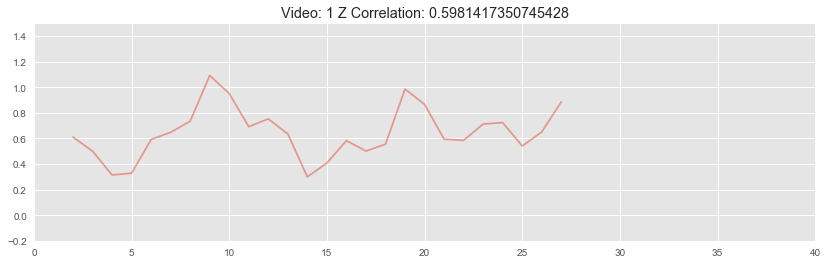

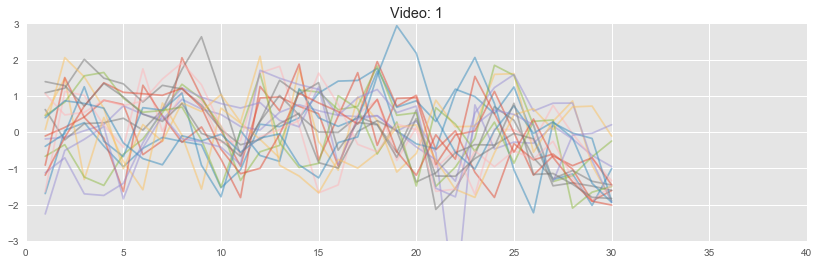

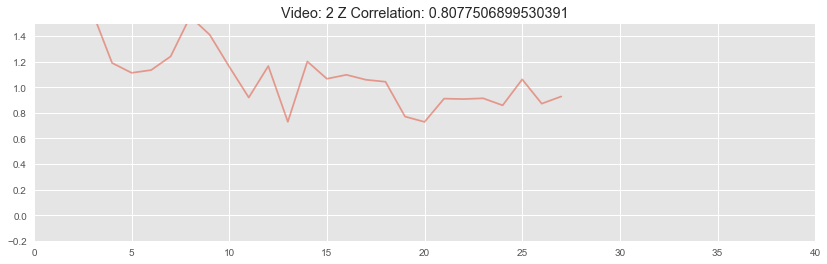

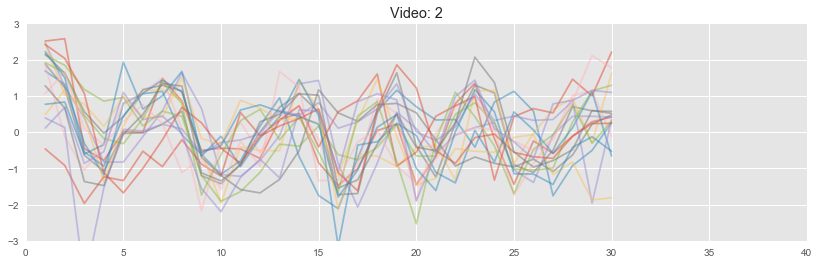

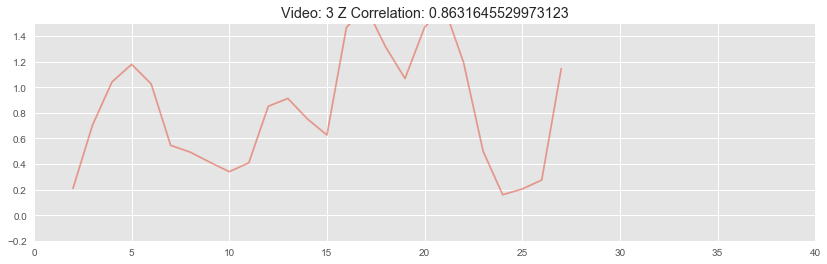

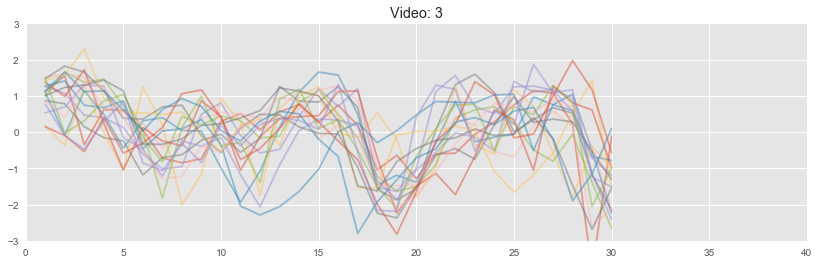

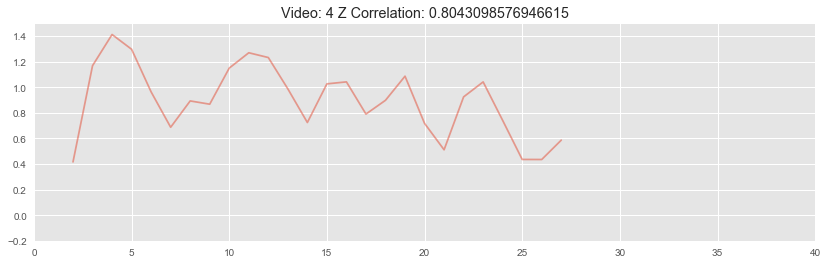

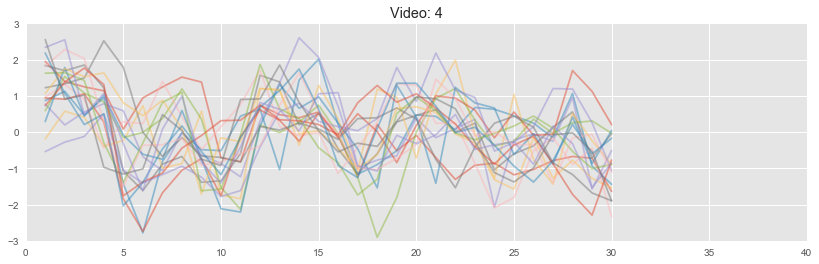

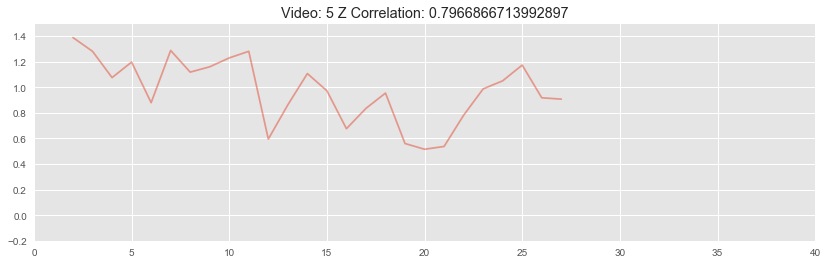

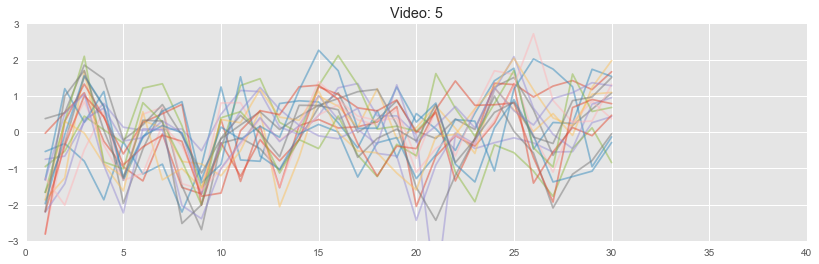

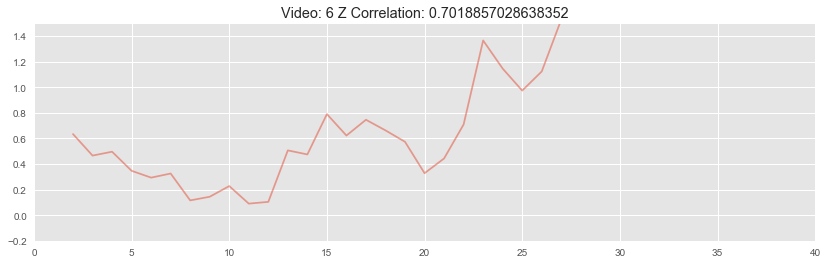

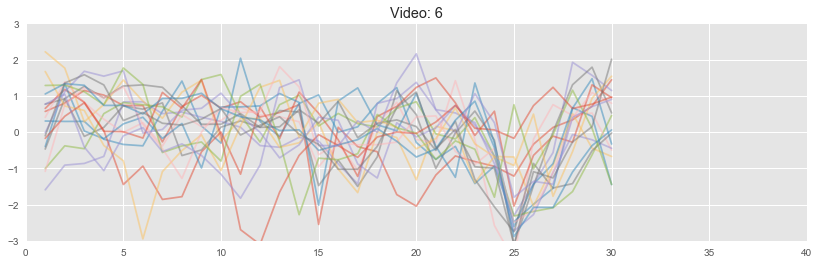

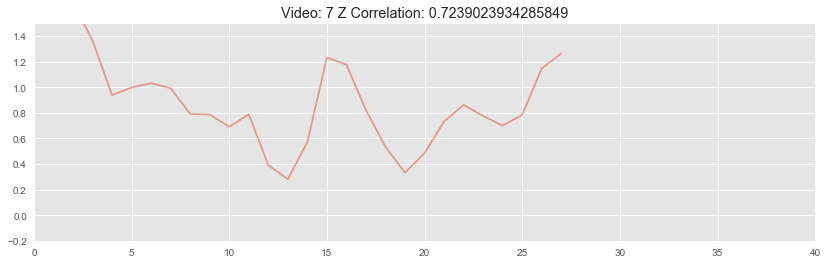

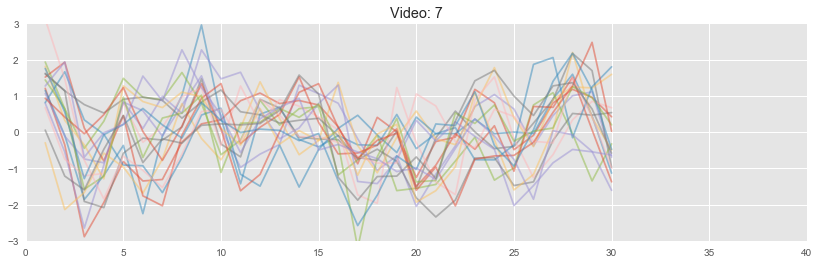

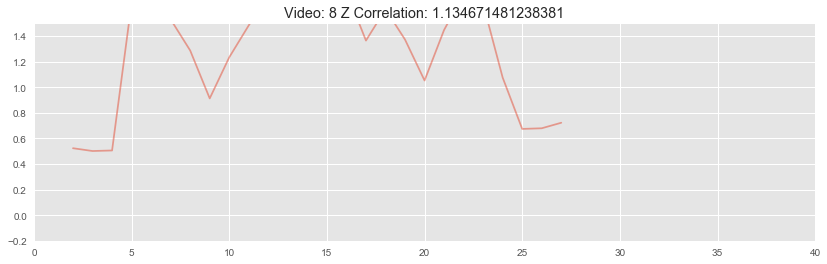

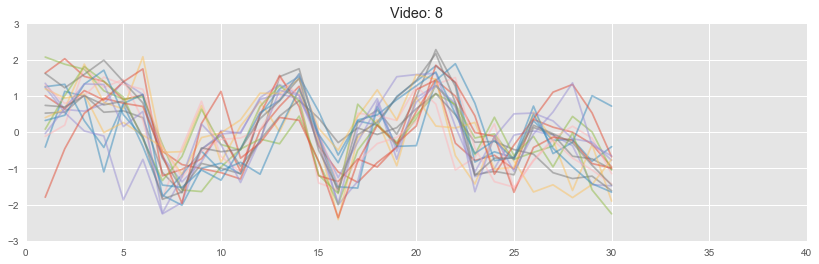

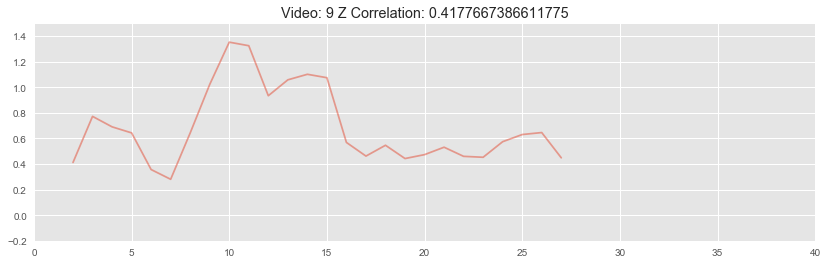

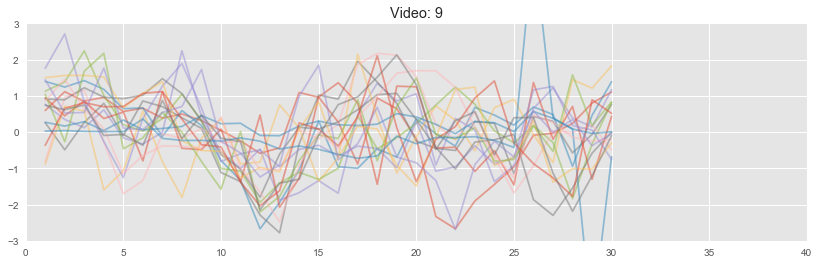

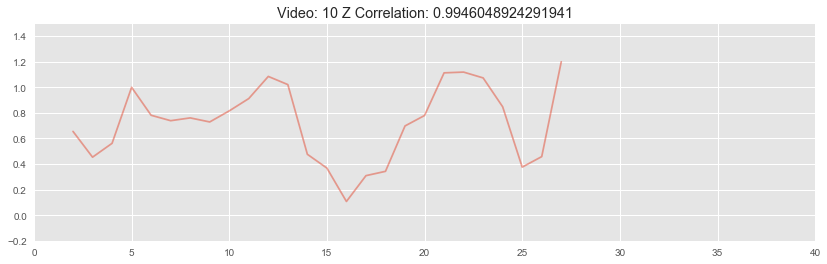

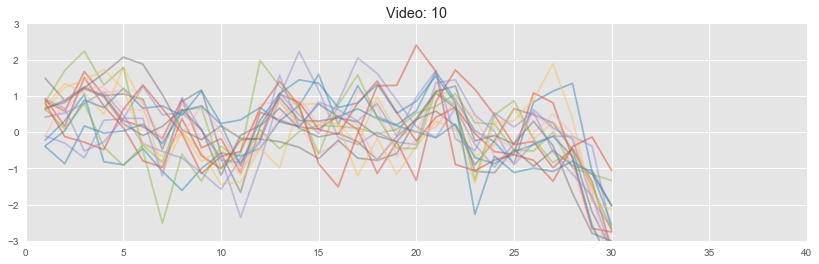

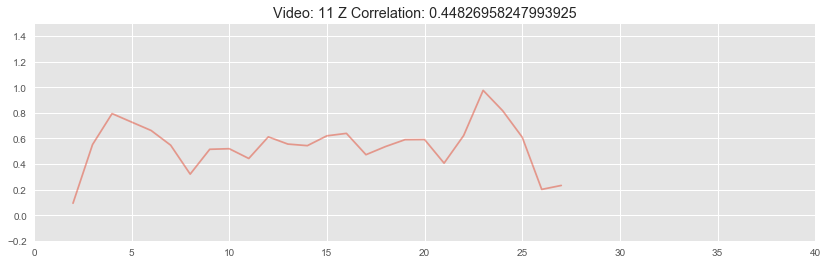

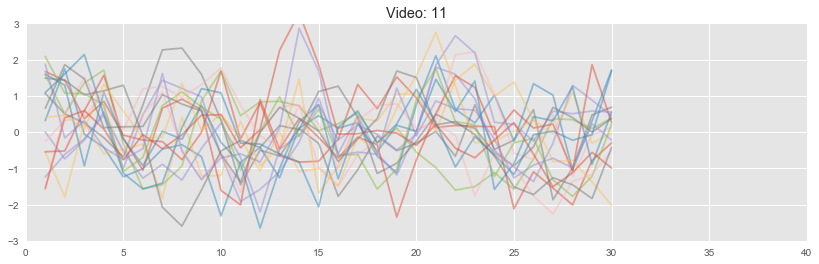

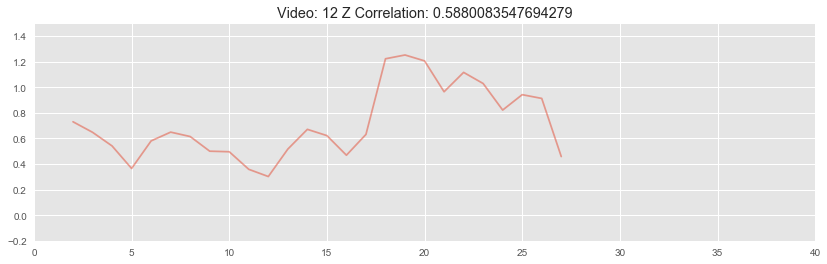

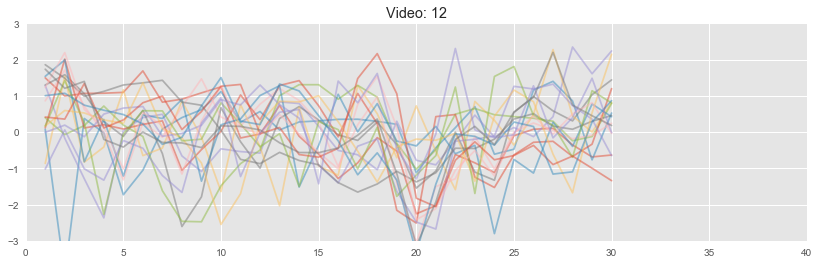

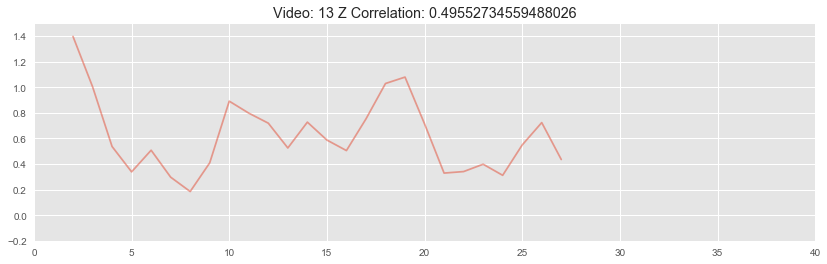

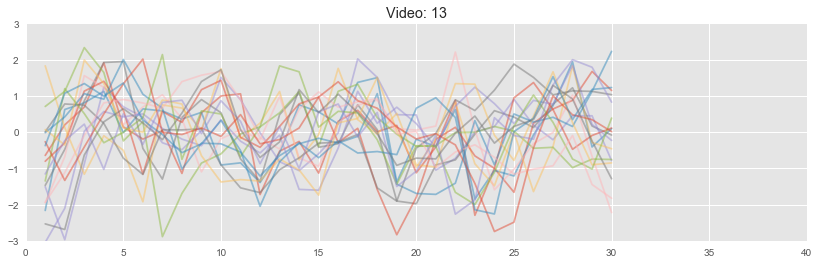

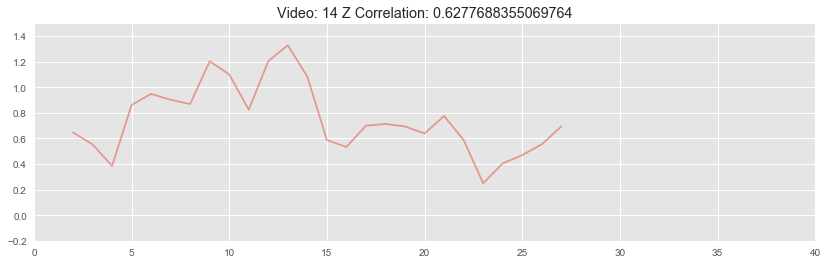

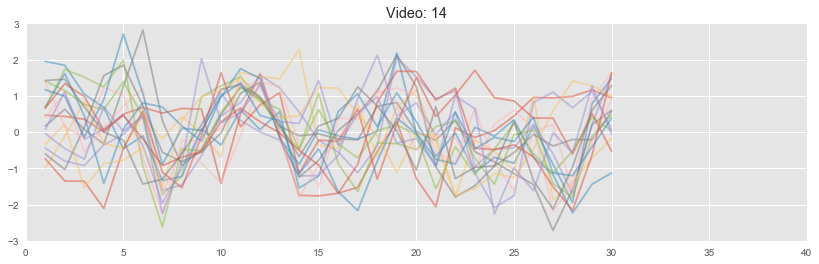

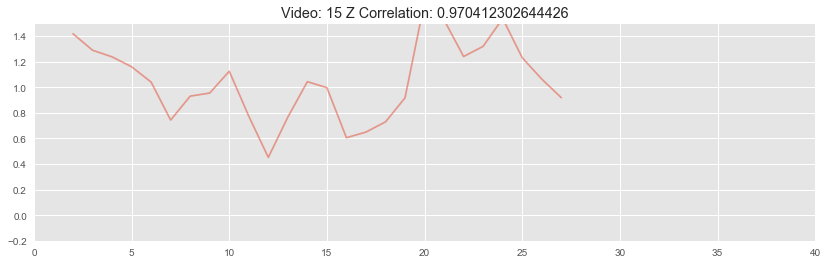

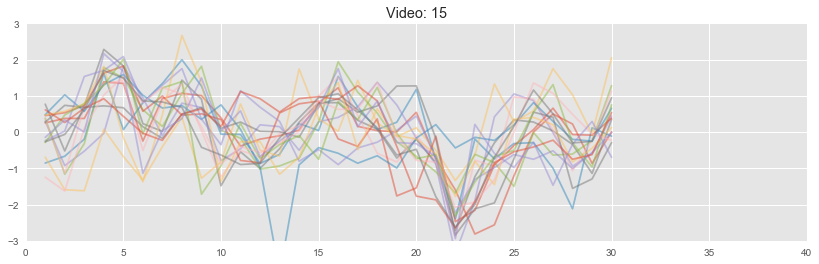

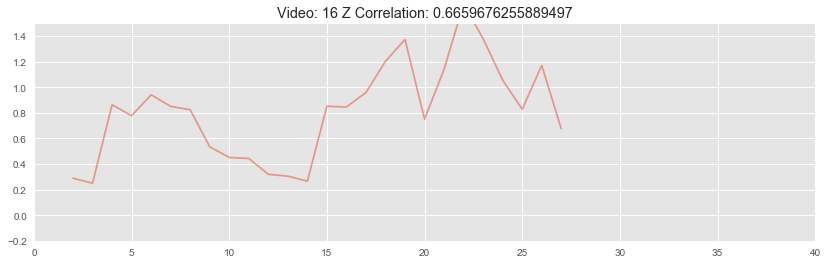

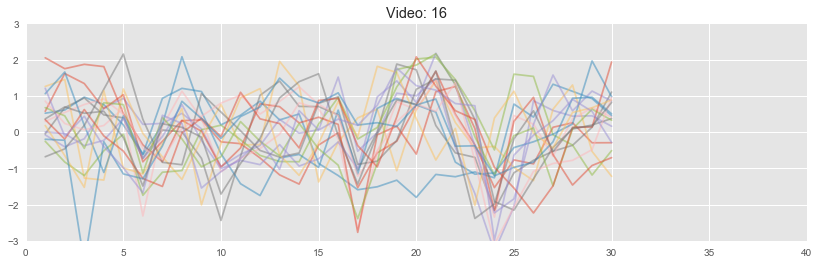

In [80]:
#Sliding window
def calculate_aver_correlation(all_video_data): 
    
    corr_values = []
    
    for subject in subjects: 
        #Get everyone else's data
        subject_data = all_video_data[subject]
        mean_data = all_video_data.loc[:, all_video_data.columns != 'second']
        mean_data = mean_data.mean(axis=1) #Mean along columns of everyone's data
        
        corr_values.append([subject,subject_data.corr(mean_data)])
        
    corr_values = pd.DataFrame(corr_values)
    corr_values.columns = ['sub', 'corr']
    
    corr_values['z'] = 0.5*np.log((1+corr_values['corr'])/(1-corr_values['corr']))
    corr_values['z'] = pd.to_numeric(corr_values['z'], errors='coerce')
    corr_values = corr_values.replace([np.inf, -np.inf], np.nan)
    
    #sns.distplot(corr_values['z'].dropna())
    return(corr_values['z'].mean())



for video in range(1, 17): 
    
    num_TRs = 30
    z_correlations = []
    z_ratings = []
    window = 2

    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    
    
    for i, subject in enumerate(subjects):
        csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")

        try: 
        
            if mask_region == 'a1_rev':
                # Load in their data
                sub_roi = pd.read_csv(csv_path, header=None)
                sub_roi = sub_roi.transpose()#only for aud_1
                subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 1:num_TRs + 1,0] # just grab the numpy array values (normally just [1])
            else: 
                # Load in their data
                sub_roi = pd.read_csv(csv_path, header=None)
                subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs ,1] # just grab the numpy array values (normally just [1])
 
        except: pass
    

    all_video_data = pd.DataFrame(subject_timeseres.transpose())
    all_video_data.columns = subjects
    all_video_data['second'] = all_video_data.index  + 1



    # Get Z scored correlations and ratings    
    for timepoint in range(window, int(all_video_data['second'].max()-window), 1):
        cropped_video_data = all_video_data[(all_video_data['second'] >= timepoint - window) &\
                                        (all_video_data['second'] <= timepoint + window) ] 
        cropped_video_data_dropped = cropped_video_data.drop(['second'], axis=1)

        z_correlations.append([video, timepoint, calculate_aver_correlation(cropped_video_data_dropped)])

        #z_ratings.append([video, timepoint, y.ix[timepoint-window:timepoint+window,:].stack().mean() ]); 

    z_correlations = pd.DataFrame(z_correlations)    
    average_z_correlation = calculate_aver_correlation(all_video_data.drop(['second'], axis=1))
    #z_ratings = pd.DataFrame(z_ratings)    
        #z_correlations = pd.DataFrame(z_correlations)    
             
        
    # Plot data
    x = z_correlations[1]
    y = z_correlations[2]
    plt.figure(figsize=(14,4))
    plt.xlim(0,40)
    plt.ylim(-.2,1.5)
    plt.title('Video: ' + str(video) + " Z Correlation: " + str(average_z_correlation))
    plt.plot(x, y, alpha=.5);
    
    
    
    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1)
    
    cols = list(y.columns)
    for col in cols:
        col_zscore = col
        y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)
    
    
    plt.figure(figsize=(14,4))
    plt.xlim(0,40)
    plt.ylim(-3,3)
    plt.title('Video: ' + str(video))
    plt.plot(x, y, alpha=.5);
    
    
    

In [64]:
# # Compute Subject Level Z-Scored Correlations
# transformedcorrs = pd.DataFrame(sub_corrs)
# transformedcorrs = transformedcorrs.replace(1,nan)
# #transformedcorrs = 0.5*np.log((1+transformedcorrs)/(1-transformedcorrs))

# transformedcorrs.mean()

# transformedcorrs
#subjects.append('seconds')
#all_video_data.columns = subjects

all_video_data



,145,157,168,184,200,214,219,220,222,223,229,245,253,257,263,267,270,277,second
0,2835.047852,3005.238037,2943.269043,2660.140137,3053.010254,3047.479248,2949.249023,2513.303467,2872.486572,2788.115234,2779.635254,2585.646729,2773.618408,2501.601562,2783.438721,2907.215820,2747.900635,2747.033936,1
1,2836.518066,3022.086914,2944.333252,2650.849121,3060.384766,3050.098877,2981.310547,2529.110107,2875.358643,2791.332520,2780.946045,2606.546631,2778.166748,2495.964600,2798.187744,2913.648682,2771.470703,2746.074707,2
2,2838.316162,3024.156982,2948.422119,2655.839600,3040.071289,3042.798340,2980.014404,2521.907471,2885.849609,2783.608398,2789.089600,2600.943359,2787.012207,2496.651855,2810.436279,2912.644287,2775.613770,2741.179688,3
3,2841.205322,3017.900146,2952.310791,2656.112549,3052.523438,3040.925293,2970.478271,2518.188477,2873.635498,2783.265381,2783.773926,2591.813477,2788.146240,2499.919189,2819.510498,2910.836670,2780.404541,2746.626221,4
4,2840.463867,3012.413818,2964.074707,2657.481934,3043.709473,3047.934570,2963.415771,2508.535156,2870.166016,2785.867188,2782.166504,2574.222168,2779.470703,2498.434326,2815.794678,2897.621582,2753.505371,2743.391113,5
5,2831.843994,3017.303467,2958.794922,2653.846191,3038.019531,3051.357910,2988.524902,2527.723145,2881.156738,2794.557373,2777.042480,2587.089844,2774.776367,2499.670654,2815.231201,2891.645508,2772.433350,2739.226318,6
6,2834.224365,3020.207031,2955.464844,2660.145020,3055.425781,3057.281250,2968.489258,2522.193848,2880.599609,2801.671143,2781.748779,2582.173096,2775.389160,2505.512207,2814.619873,2889.292969,2784.475830,2737.486084,7
7,2848.510254,3019.144287,2968.181396,2672.458740,3048.965576,3063.697754,2981.093262,2517.427246,2884.447998,2806.287109,2780.721191,2593.401611,2776.515137,2509.833008,2817.380371,2900.350586,2775.783936,2741.794678,8
8,2841.737305,3018.236084,2962.104980,2682.453613,3038.155518,3060.367432,2978.068359,2520.192871,2868.256836,2804.307373,2776.160889,2590.885742,2765.485840,2503.986572,2809.883545,2898.377930,2774.701660,2734.610840,9
9,2835.990234,3006.799316,2958.667969,2664.810303,3054.401611,3054.192139,2964.953857,2514.381592,2861.175293,2802.932861,2769.320557,2595.818604,2749.637939,2493.002930,2793.529785,2900.904297,2772.701416,2732.898438,10


Few other pointers:  

If you want to do ISC for multiple ROIs you'll probably want to do something like load in a single subject, loop over a `Brain_Data` object containing multiple ROIs, use the `extract` method to grab mean timeseries from each, then save all those to a single csv file for that subject using pandas or numpy. Then after you've done that for each subject just load in their csv files and proceed with correlating them as you want. This probably the fastest way to do it because very few computers can load say 30 subjects full time-series of a few minutes into RAM at once (unless maybe the time-series are very short). So this way just extracts all the ROIs for each subject first then lets you do whatever analyses you want on them. 